In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import glob
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.auto import trange
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb, RandomEmbeddingEncoder
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks, evaluate_parametric_relation
from utils.cv2_eval_utils import find_classify_objects, evaluate_parametric_relation, eval_func_factory, scene_info_collection
from utils.attention_analysis_lib import plot_attention_layer_head_heatmaps, plot_layer_head_score_summary
from utils.attention_analysis_lib import *
from utils.obj_mask_utils import *
from circuit_toolkit.plot_utils import saveallforms
import pandas as pd
from tqdm.auto import tqdm

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [13]:
def build_model_and_pipeline(savedir, ckpt_name=None, overwrite_work_dir=False):
    config = read_config(join(savedir, 'config.py'))
    if overwrite_work_dir:
        config.work_dir = savedir
    weight_dtype = torch.float32
    if config.mixed_precision == "fp16": # accelerator.
        weight_dtype = torch.float16
    elif config.mixed_precision == "bf16": # accelerator.
        weight_dtype = torch.bfloat16
    print(f"weight_dtype: {weight_dtype}")
    image_size = config.image_size  # @param [256, 512, 1024]
    latent_size = int(image_size) // 8
    pred_sigma = getattr(config, 'pred_sigma', True)
    learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
    model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                    "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                    'model_max_length': config.model_max_length}
    # train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
    model = build_model(config.model,
                    config.grad_checkpointing,
                    config.get('fp32_attention', False),
                    input_size=latent_size,
                    learn_sigma=learn_sigma,
                    pred_sigma=pred_sigma,
                    **model_kwargs).train()
    num_layers = len(model.blocks)
    transformer = Transformer2DModel(
            sample_size=image_size // 8,
            num_layers=len(model.blocks),
            attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
            in_channels=model.in_channels,
            out_channels=model.out_channels,
            patch_size=model.patch_size,
            attention_bias=True,
            num_attention_heads=model.num_heads,
            cross_attention_dim=model.blocks[0].hidden_size,
            activation_fn="gelu-approximate",
            num_embeds_ada_norm=1000,
            norm_type="ada_norm_single",
            norm_elementwise_affine=False,
            norm_eps=1e-6,
            caption_channels=4096,
    )
    # state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
    transformer.load_state_dict(state_dict_convert(model.state_dict()))
    pipeline = PixArtAlphaPipeline_custom.from_pretrained(
        "PixArt-alpha/PixArt-XL-2-512x512",
        transformer=transformer,
        tokenizer=None,
        text_encoder=None,
        torch_dtype=weight_dtype,
    )
    ckptdir = join(savedir, "checkpoints")
    if ckpt_name is not None:
        ckpt = torch.load(join(ckptdir, ckpt_name))
        pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
    # pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
    pipeline.to(device="cuda", dtype=weight_dtype);
    return model, pipeline

In [15]:
def build_text_encoder(text_encoder_type):
    T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
    tokenizer = T5Tokenizer.from_pretrained(T5_path, ) #subfolder="tokenizer")
    if text_encoder_type == "T5":
        print("Using T5 encoder")
        # T5_dtype = {"bfloat16": torch.bfloat16, "float16": torch.float16, "float32": torch.float32}[args.T5_dtype]
        T5_dtype = torch.bfloat16
        text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=T5_dtype, )
        print("T5 encoder loaded")
    elif text_encoder_type == "RandomEmbeddingEncoder_wPosEmb":
        # text_feat_path_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/random_emd_dictionary/word_embedding_dict.pt'
        text_feat_path_new = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/random_emd_dictionary/word_embedding_dict_randemb_new.pt'
        print("Using RandomEmbeddingEncoder_wPosEmb encoder with new word embedding dictionary : ", text_feat_path_new)
        emb_data = th.load(text_feat_path_new) 
        text_encoder = RandomEmbeddingEncoder_wPosEmb(emb_data["embedding_dict"], 
                                                    emb_data["input_ids2dict_ids"], 
                                                    emb_data["dict_ids2input_ids"], 
                                                    max_seq_len=20, embed_dim=4096,
                                                    wpe_scale=1/6).to("cuda")
        print("RandomEmbeddingEncoder_wPosEmb encoder loaded")
    elif text_encoder_type == "RandomEmbeddingEncoder":
        # text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/objectRel_pilot_rndemb/caption_feature_wmask'
        # text_feat_path_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/random_emd_dictionary/word_embedding_dict.pt'
        text_feat_path_new = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/random_emd_dictionary/word_embedding_dict_randemb_new.pt'
        emb_data = th.load(text_feat_path_new) 
        print("Using RandomEmbeddingEncoder_wPosEmb encoder with new word embedding dictionary : ", text_feat_path_new)
        text_encoder = RandomEmbeddingEncoder(emb_data["embedding_dict"], 
                                                    emb_data["input_ids2dict_ids"], 
                                                    emb_data["dict_ids2input_ids"], 
                                                    ).to("cuda")
        print("RandomEmbeddingEncoder encoder loaded")
    return text_encoder, tokenizer

In [5]:
model_run_name = "hannah_results/objrel_mixedobj_mini_rndembpos"
text_encoder_type = "RandomEmbeddingEncoder_wPosEmb"
suffix = ""

In [42]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/

feature_map_pilot
hannah_results
objrel2_DiT_B_pilot
objrel_DiT_B_pilot
objrel_multiobj_T5_DiT_B_pilot1
objrel_pilot
objrel_rndemb_DiT_B_pilot
objrel_rndembdposemb_DiT_B_pilot
objrel_rndembdposemb_DiT_micro_pilot
objrel_rndembdposemb_DiT_mini_pilot
objrel_rndembdposemb_DiT_nano_pilot
objrel_singleobj_T5_DiT_B_pilot
objrel_singleobj_T5_DiT_B_pilot2
objrel_singleobj_T5_DiT_B_pilot3
objrel_singleobj_T5_DiT_B_pilot4
objrel_singleobj_T5_DiT_mini_pilot4
objrel_singleobj_T5_DiT_mini_randomized_pilot1
objrel_T5_DiT_B_pilot
objrel_T5_DiT_B_pilot_failedrun
objrel_T5_DiT_B_pilot_WDecay
objrel_T5_DiT_mini_pilot
objrel_T5_DiT_mini_pilot_WDecay
pretrained


In [ ]:
model_run_name = "hannah_results/objrel_doubleobj_mini_rndembpos"
model_run_name = "objrel_rndembdposemb_DiT_mini_pilot"
text_encoder_type = "RandomEmbeddingEncoder_wPosEmb"
suffix = ""

savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
# figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
result_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/analysis_results/{model_run_name}{suffix}"
eval_dir = join(savedir, "large_scale_eval_posthoc")
os.makedirs(eval_dir, exist_ok=True)
text_encoder, tokenizer = build_text_encoder(text_encoder_type)
model, pipeline = build_model_and_pipeline(savedir, ckpt_name="epoch_4000_step_160000.pth", overwrite_work_dir=True)
pipeline.tokenizer = tokenizer
pipeline.text_encoder = text_encoder
pipeline.to(device="cuda", ); # dtype=torch.float16

/tmp/ipykernel_2560443/3791866253.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_data = th.load(text_feat_path_new)
2025-08-01 18:45:08,401 - PixArt - WARNING - le

Using RandomEmbeddingEncoder_wPosEmb encoder with new word embedding dictionary :  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/random_emd_dictionary/word_embedding_dict_randemb_new.pt
RandomEmbeddingEncoder_wPosEmb encoder loaded
weight_dtype: torch.float16


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_2560443/541097944.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

In [49]:
model_run_name = "objrel_rndembdposemb_DiT_mini_pilot"
text_encoder_type = "RandomEmbeddingEncoder_wPosEmb"
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
text_encoder, tokenizer = build_text_encoder(text_encoder_type)
model, pipeline = build_model_and_pipeline(savedir, ckpt_name="epoch_4000_step_160000.pth", overwrite_work_dir=True)
pipeline.tokenizer = tokenizer
pipeline.text_encoder = text_encoder
pipeline.to(device="cuda", ); # dtype=torch.float16

/tmp/ipykernel_2560443/3791866253.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_data = th.load(text_feat_path_new)
2025-08-01 18:47:52,023 - PixArt - WARNING - le

Using RandomEmbeddingEncoder_wPosEmb encoder with new word embedding dictionary :  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/random_emd_dictionary/word_embedding_dict_randemb_new.pt
RandomEmbeddingEncoder_wPosEmb encoder loaded
weight_dtype: torch.float16


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_2560443/541097944.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

torch.Size([50, 20, 4096])
torch.Size([50, 20])


  0%|          | 0/25 [00:00<?, ?it/s]

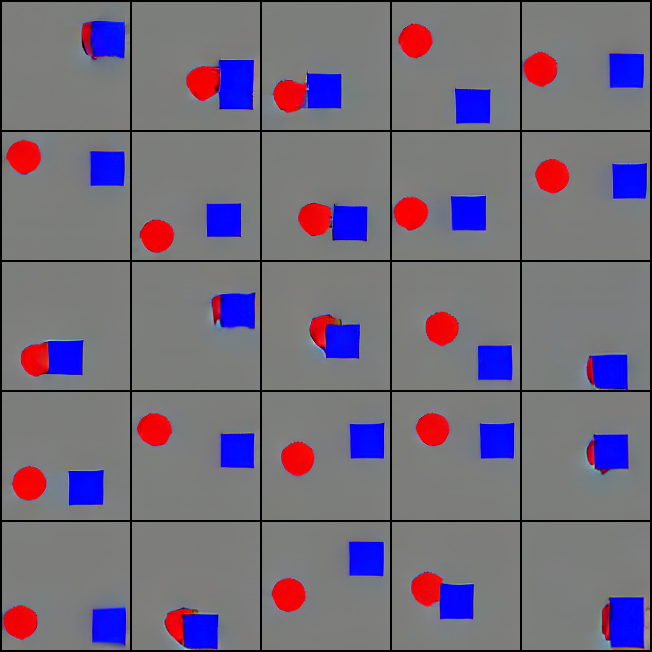

In [51]:
out = pipeline("red circle is to the left of blue square", num_inference_steps=25, guidance_scale=4.5, max_sequence_length=20, 
        num_images_per_prompt=25, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.float16)
pil_images_to_grid(out.images)

In [52]:
# model_run_name = "objrel_rndembdposemb_DiT_mini_pilot"
model_run_name = "hannah_results/objrel_doubleobj_mini_rndembpos"
text_encoder_type = "RandomEmbeddingEncoder_wPosEmb"
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
text_encoder, tokenizer = build_text_encoder(text_encoder_type)
model, pipeline = build_model_and_pipeline(savedir, ckpt_name="epoch_4000_step_160000.pth", overwrite_work_dir=True)
pipeline.tokenizer = tokenizer
pipeline.text_encoder = text_encoder
pipeline.to(device="cuda", ); # dtype=torch.float16

/tmp/ipykernel_2560443/3791866253.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_data = th.load(text_feat_path_new)
2025-08-01 18:48:53,315 - PixArt - WARNING - le

Using RandomEmbeddingEncoder_wPosEmb encoder with new word embedding dictionary :  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/random_emd_dictionary/word_embedding_dict_randemb_new.pt
RandomEmbeddingEncoder_wPosEmb encoder loaded
weight_dtype: torch.float16


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_2560443/541097944.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

torch.Size([50, 20, 4096])
torch.Size([50, 20])


  0%|          | 0/25 [00:00<?, ?it/s]

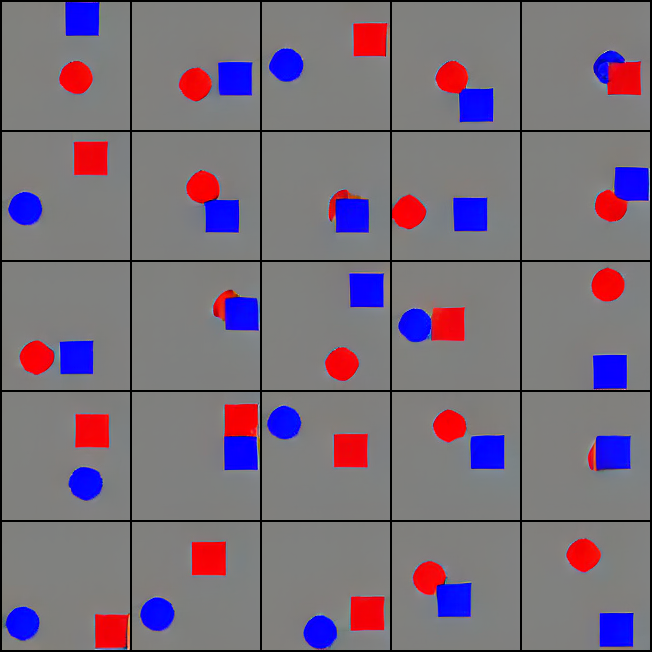

In [53]:
out = pipeline("red circle is to the left of blue square", num_inference_steps=25, guidance_scale=4.5, max_sequence_length=20, 
        num_images_per_prompt=25, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.float16)
pil_images_to_grid(out.images)

torch.Size([50, 20, 4096])
torch.Size([50, 20])


  0%|          | 0/25 [00:00<?, ?it/s]

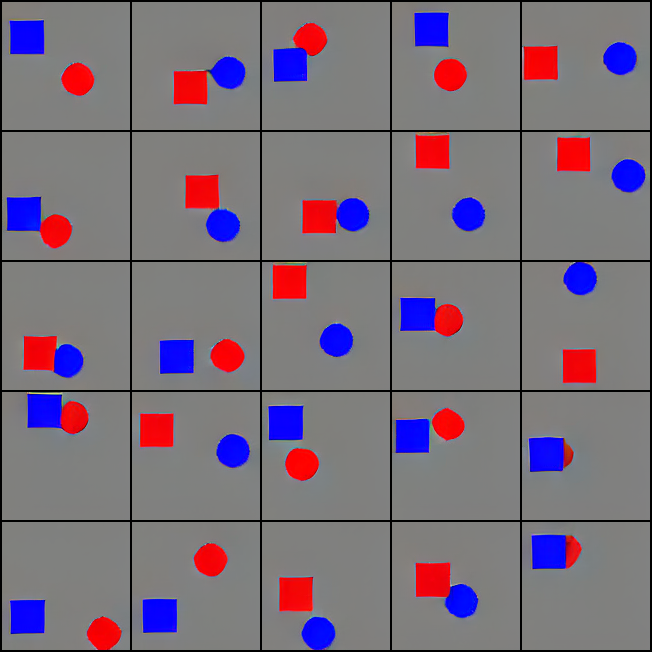

In [41]:
out = pipeline("red circle is to the right of blue square", num_inference_steps=25, guidance_scale=4.5, max_sequence_length=20, 
        num_images_per_prompt=25, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.float16)
pil_images_to_grid(out.images)

### Scratch


In [8]:
config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
print(f"weight_dtype: {weight_dtype}")
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)
transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
# ckptdir = join(savedir, "checkpoints")
# ckpt = torch.load(join(ckptdir, ckpt_name))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.to(device="cuda", dtype=weight_dtype);

weight_dtype: torch.float16


FileNotFoundError: PixArt_mini_2: [Errno 2] No such file or directory: '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_mixedobj_mini_rndembpos/train_log.log'

In [ ]:

# pipeline.to(device="cuda", dtype=torch.bfloat16);
pipeline.tokenizer = tokenizer
pipeline.text_encoder = text_encoder.to(device="cuda", )
# add attention map store hooks
# pipeline.transformer = replace_attn_processor(pipeline.transformer)
# attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
# attnvis_store.setup_hooks()
# torch.cuda.empty_cache()

# %%
# test one prompt works. 
out = pipeline("blue square below and to the right of red circle", num_inference_steps=14, guidance_scale=4.5, max_sequence_length=20, 
        num_images_per_prompt=4, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=torch.float16)